In [1]:
import pandas as pd
from progressbar import ProgressBar
import warnings
import re
from imdb import IMDb
ia = IMDb()
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [2]:
import spacy
import numpy as np
nlp = spacy.load("en_core_web_sm")

In [3]:
# from PyDictionary import PyDictionary
# dictionary=PyDictionary()
import pickle

In [4]:
def getIMDBmovies():
    imdb_movies = pd.read_json('../data/task2/imdb_dataset.json')
    imdb_movies = imdb_movies[['title', 'year', 'imdb_url']]
    imdb_movies = imdb_movies.rename(columns={"title": "Movie", "year":"Year"})
    imdb_movies = imdb_movies.sort_values(by=['Movie'], ignore_index=True)
    return imdb_movies

In [5]:
def getMovieID(moviename, year):
    try:
        dataset = pd.read_csv('../data/task2/all-charachters.csv', delimiter=',')
        found = dataset.loc[((dataset['Movie'] == moviename) | (dataset['AltTitle'] == moviename)) & (dataset['Year']==float(year))]
        if found.shape[0] == 1:
            m = found['imdb_url'].to_string(index=False)
            m = m.replace(' ', '')
            return m[29:36]
        else: e
    except:
        try:
            dataset = getIMDBmovies()
            found = dataset.loc[((dataset['Movie'] == moviename) & (dataset['Year']==float(year)))]
            if found.shape[0] == 1:
                m = found['imdb_url'].to_string(index=False)
                m = m.replace(' ', '')
                return m[29:36]
            else: e
        except:
            print("Processing...")
            try:
                movies = ia.search_movie(moviename)
                for movie in movies:
                    myear = movie['year']
                    if myear == year:
                        return movie.movieID
            except:
                print("Cannot find movie on IMDB.")

In [6]:
def getCast(moviename, year):
    print('Procuring Cast...')
    try:
        c = []
        mid = getMovieID(moviename, year)
        m = ia.get_movie(mid)
        cast = m['cast']
        for actor in cast:
            c.append(actor)
            c.append(actor.currentRole)
        return c
    except:
        print("Cannot find movie on IMDB.")

In [7]:
def checkMultipleRoles(characters):
    c = characters.copy()
    for i,char in enumerate(c):
        if '/' in char:
            chars = char.split(' / ')
            characters[i] = chars[0]
            for j in range(1, len(chars)):
                characters.append(chars[j])
    return characters

In [8]:
def getCharacters(cast):
    allcharacters = cast[0::2]
    characters=[]
    for character in allcharacters:
        char = str(character)
        newc = re.sub(r"(.*)(name:_)(.*)(_>)(.*)", "\3", char)
        characters.append(newc)
    
    characters = checkMultipleRoles(characters)
    return characters

In [9]:
tags = [",", "-LRB-", "-RRB-", "``", "\"\"", "''", ",", "$", "#", "AFX", "CC", "CD", "DT", 
"EX", "FW", "HYPH", "IN", "JJ", "JJR", "JJS", "LS", "MD",
"PDT", "POS", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "SYM", "TO", "UH", "VB", "VBD", 
"VBG", "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB", "ADD", "NFP", "GW", "XX", "BES", "HVS", "_SP"]
# for tag in tags:
#     print(spacy.explain(tag))
# # Rules:
# 3. If Years Old in name -> add name after that 
# 4. get first name -> If firstname in names list -> add firstname
# 7. if entire name is NER PERSON -> add first name

In [10]:
def checkRules(char):
    people = ['kid', 'man', 'woman','boy', 'girl', 'guy', 'dude', 'gal', 'chick', 'chicks']
    kin = pd.read_csv('../data/names/kinship.txt', names=['Kinship'])
    kin = list(kin['Kinship'])
    jobslist = pd.read_csv('../data/task2/job-titles.txt', names=['Job'])
    jobslist = list(jobslist['Job'])
    nation = pd.read_csv('../data/task2/nationality.txt', names=['Nationality'])
    nation = list(nation['Nationality'])
    animal = pd.read_csv('../data/task2/animals.txt')
    animal = list(animal['Animal'])
    
    #EMPTY
    if char == " " or char =="":
        return False
    
    #REGEX
    if re.search(r'#',char):
        return False
    if re.search(r'\'s', char):
        return False
    if re.search(r'[0-9]', char):
        return False
    
    #POS TAG
    doc = nlp(char)
    count =0
    total=0
    for token in doc:
        total += 1
        if token.tag_ in tags:
            return False
        if token.tag_ == "NNS" or token.tag_ == "NN":
            count += 1
    if total == count and total !=0:
        return False
    

    chars = char.split(' ')
    
    for c in chars:
#         print(c.lower())
        if c.lower() in jobslist:
            return False
        elif c.lower() in people:
            return False
        elif c.lower() in kin:
            return False
        elif c.lower() in nation:
            return False
        elif c.lower() in animal:
            return False
    
    #JOB TITLE
    if char.lower() in jobslist:
        return False
    
    #PEOPLE
    if char.lower() in people:
        return False
    
    #KINSHIP
    if char.lower() in kin:
        return False
    
    #Nationality
    if char.lower() in nation:
        return False
    
        #Animals
    if char.lower() in animal:
        return False
    
    return True

In [11]:
def getNamedCharacters(characters):
    c=1
    namedchar=[]
    nameslist = pd.read_csv('../data/names/all-names.csv')
    nameslist = list(nameslist['Name'])
    for character in characters:
        if character.lower() in nameslist:
            namedchar.append(character)
#         elif c==1:
#             for name in nameslist:
#                 char = character.lower().split(' ')
#                 for c2 in char:
#                     if name == c2:
#                         print(name, "list")
#                         namedchar.append(name.title())
        elif characters.count(character)>1:
            continue
        elif checkRules(character):
            namedchar.append(character)
        
    return namedchar

In [12]:
def getFirstName(names):
    fnames=[]
    sals = pd.read_csv('../data/task2/salutation.txt', names=['Salutation'])
    sals = list(sals['Salutation'].str.title())
    for name in names:
        name = name.title()
        for sal in sals:
            if sal in name:
                name = name.replace(sal, '')
                name = name.strip()
        name = name.title()
        doc = nlp(name)
        if len(doc) ==1:
            fnames.append(name)
        elif len(doc) ==2:
            if (doc[0].tag_=="NNS" or doc[0].tag_=="NN" or doc[0].pos_=="SPACE"):
                fnames.append(doc[1].text)
            else:
                fnames.append(doc[0].text)
        else:
            fnames.append(doc[0].text)
    return fnames

In [13]:
# Features

In [14]:
def checkEnd(name):
    if name[-1] in "aeiou":
        return "vowel"
    return "consonant"

In [15]:
def letterClass(name):
    name_list = [x for x in name]
    vowel_counter = 0
    consonant_counter = 0
    for letter in name_list:
        if letter in ['a','e','i','o','u']:
            vowel_counter+=1
        else:
            consonant_counter+=1
    
    return vowel_counter, consonant_counter


In [16]:
def checkVCDifference(data):
    data['vcDifference']= data['ConsonantCount'] - data['VowelCount']

In [17]:
def checkVowelCount(col):
    if col > 2:
        return 'more'
    return 'less'

def checkConsonantCount(col):
    if col > 3:
        return 'more'
    return 'less'

In [18]:
def checkMoreVowels(col):
    if col == 'moreConsonants':
        return 'less'
    return 'more'

In [19]:
def checkMoreDifference(col):
    if col > 1:
        return 'more'
    return 'less'

In [20]:
def getASCII(name):
    asciiVal = 0
    for x in name:
        asciiVal += ord(x)-97
    return asciiVal/len(name)

In [21]:
def compareVowels(data):
    data['vcCompare']= np.where(data['ConsonantCount'] == data['VowelCount'], 'equal', np.where(
    data['ConsonantCount'] > data['VowelCount'], 'moreConsonants', 'moreVowels')) 

In [22]:
def dropColumns(data, collist):
    data = data.drop(columns=collist)
    return data

In [23]:
def makeBinary(data, cols, zero, one):
    for col in cols:
        data[col] = np.where((data[col] == zero),0,data[col])        
        data[col] = np.where((data[col] == one),1,data[col])
    return data

In [24]:
def getFeatures(data):
    print('Predicting Genders...')
    data["EndsWith"] = data["Name"].apply(checkEnd)
    data['VowelCount'] = data['Name'].apply(lambda x: letterClass(x)[0])
    data['ConsonantCount'] = data['Name'].apply(lambda x: letterClass(x)[1])
    checkVCDifference(data)
    data["VowelCountClass"] = data["VowelCount"].apply(checkVowelCount)
    data["ConsonantCountClass"] = data["ConsonantCount"].apply(checkConsonantCount)
    compareVowels(data)
    data["MoreVowels"] = data["vcCompare"].apply(checkMoreVowels)
    data["MoreDifferenceClass"] = data["vcDifference"].apply(checkMoreDifference)
    data["ASCIIval"] = data["Name"].apply(getASCII)
    data = dropColumns(data, ['vcCompare', 'ConsonantCountClass', 'Name'])
    data = makeBinary(data, ['VowelCountClass', 'MoreVowels', 'MoreDifferenceClass'], 'less', 'more')
    data = makeBinary(data, ['EndsWith'], 'consonant', 'vowel')
    return data

In [32]:
def plotPredictions(svm, dtc, movie, year):
    print('Plotting Distribution...')
    df = pd.DataFrame(columns=['SVM', 'LogisticRegression'])

    svm = pd.DataFrame(svm, columns=['Gender'])
    svm = pd.DataFrame(svm.value_counts(['Gender']).reset_index(name='Count'))
    
    dtc = pd.DataFrame(dtc, columns=['Gender'])
    dtc = pd.DataFrame(dtc.value_counts(['Gender']).reset_index(name='Count'))
    
    df['SVM'] = svm['Count']
    df['LogisticRegression'] = dtc['Count']
    df['Gender'] = svm['Gender']
    
    df = df.replace(0, 'Male')
    df = df.replace(1, 'Female')
    df = df.set_index('Gender')
    
    title = 'Distribution of Characters:' + movie + '(' + str(year) + ')'
    
    plot = df.plot.pie(subplots=True, figsize=(13, 5), colors = ['#66b3ff','#99ff99'], autopct = "%.2f%%", labeldistance=1.15, title=title)

In [33]:
def getPredictions(data):
    with open('./models/svm-names', 'rb') as file:  
        svm = pickle.load(file)
    predictions = svm.predict(data)
    
    with open('./models/LogReg-names', 'rb') as file2:  
        dtc = pickle.load(file2)
    predictions_dtc = dtc.predict(data)
    return predictions, predictions_dtc

In [34]:
def getDistribution(movie, year):
    cast = getCast(movie, year)
    actors = getCharacters(cast)
    fnames = getFirstName(actors)
    data = pd.DataFrame(fnames, columns=['Name'])
    data = getFeatures(data)
    svm, dtc = getPredictions(data)
    plotPredictions(svm, dtc, movie, year)

Procuring Cast...
Processing...
Predicting Genders...
Plotting Distribution...


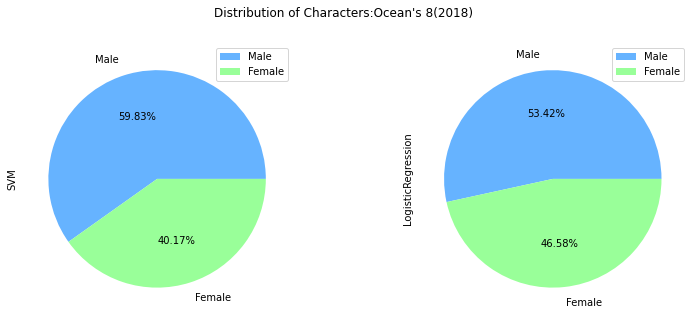

In [43]:
movie ='Ocean\'s 8'
year = 2018
getDistribution(movie, year)